<a href="https://colab.research.google.com/github/rebeccadimatteo/FitDiary_FIA/blob/main/regressionNoFeatureScaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressione SENZA Feature Scaling

## Ottenimento del Dataset

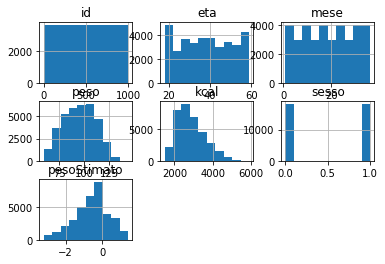

,id,eta,mese,peso,kcal,sesso,pesoStimato
0,1,24,1,107.00000,2688,0,-1.848958
1,1,24,2,108.84896,2538,0,-0.940110
2,1,24,3,109.78907,2929,0,-0.564015
3,1,24,4,110.35309,2526,0,-0.984957
4,1,24,5,111.33804,2658,0,-2.140707


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from six.moves import urllib

DOWNLOAD_ROOT="https://raw.githubusercontent.com/rebeccadimatteo/FitDiary_FIA/master/dataset.csv"

def fetch_file_data1(file_url1=DOWNLOAD_ROOT, file_path1="file"):
  os.makedirs(file_path1, exist_ok=True)
  csv_path1 = os.path.join(file_path1, "datasetRegressioneNoFeatureScaling.csv")
  urllib.request.urlretrieve(file_url1, csv_path1)
fetch_file_data1()

#df è la variabile che contiene il dataset
df=pd.read_csv("file/datasetRegressioneNoFeatureScaling.csv")
df=df[["id", "eta", "mese", "peso", "kcal", "sesso", "pesoStimato"]]
df.hist()
plt.show()
df.head(5)

## 1) Data Cleaning

### 1.1) Descrizione del Dataset 

In [ ]:
df.describe()

,id,eta,mese,peso,kcal,sesso,pesoStimato
count,36000.000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000
mean,500.500,38.308000,18.500000,95.203136,2879.582611,0.497000,-0.571741
std,288.679,12.166234,10.388439,16.069207,738.609226,0.499998,0.929684
min,1.000,18.000000,1.000000,59.222496,1488.000000,0.000000,-3.196685
25%,250.750,28.000000,9.750000,82.672719,2313.000000,0.000000,-1.128062
50%,500.500,38.000000,18.500000,95.666960,2753.000000,0.000000,-0.468522
75%,750.250,49.000000,27.250000,107.738935,3322.000000,1.000000,0.000000
max,1000.000,59.000000,36.000000,143.836010,5895.000000,1.000000,1.402878


### 1.2) Verifica dei valori null

In [ ]:
#verifica se ci sono dati null nel dataset
df.isnull().any()

id             False
eta            False
mese           False
peso           False
kcal           False
sesso          False
pesoStimato    False
dtype: bool

### 1.3) Verifica valori N/A nel dataset

In [ ]:
#verifica se ci sono dati NA nel dataset
df.isna().any()

id             False
eta            False
mese           False
peso           False
kcal           False
sesso          False
pesoStimato    False
dtype: bool

### 1.4) Dataplot

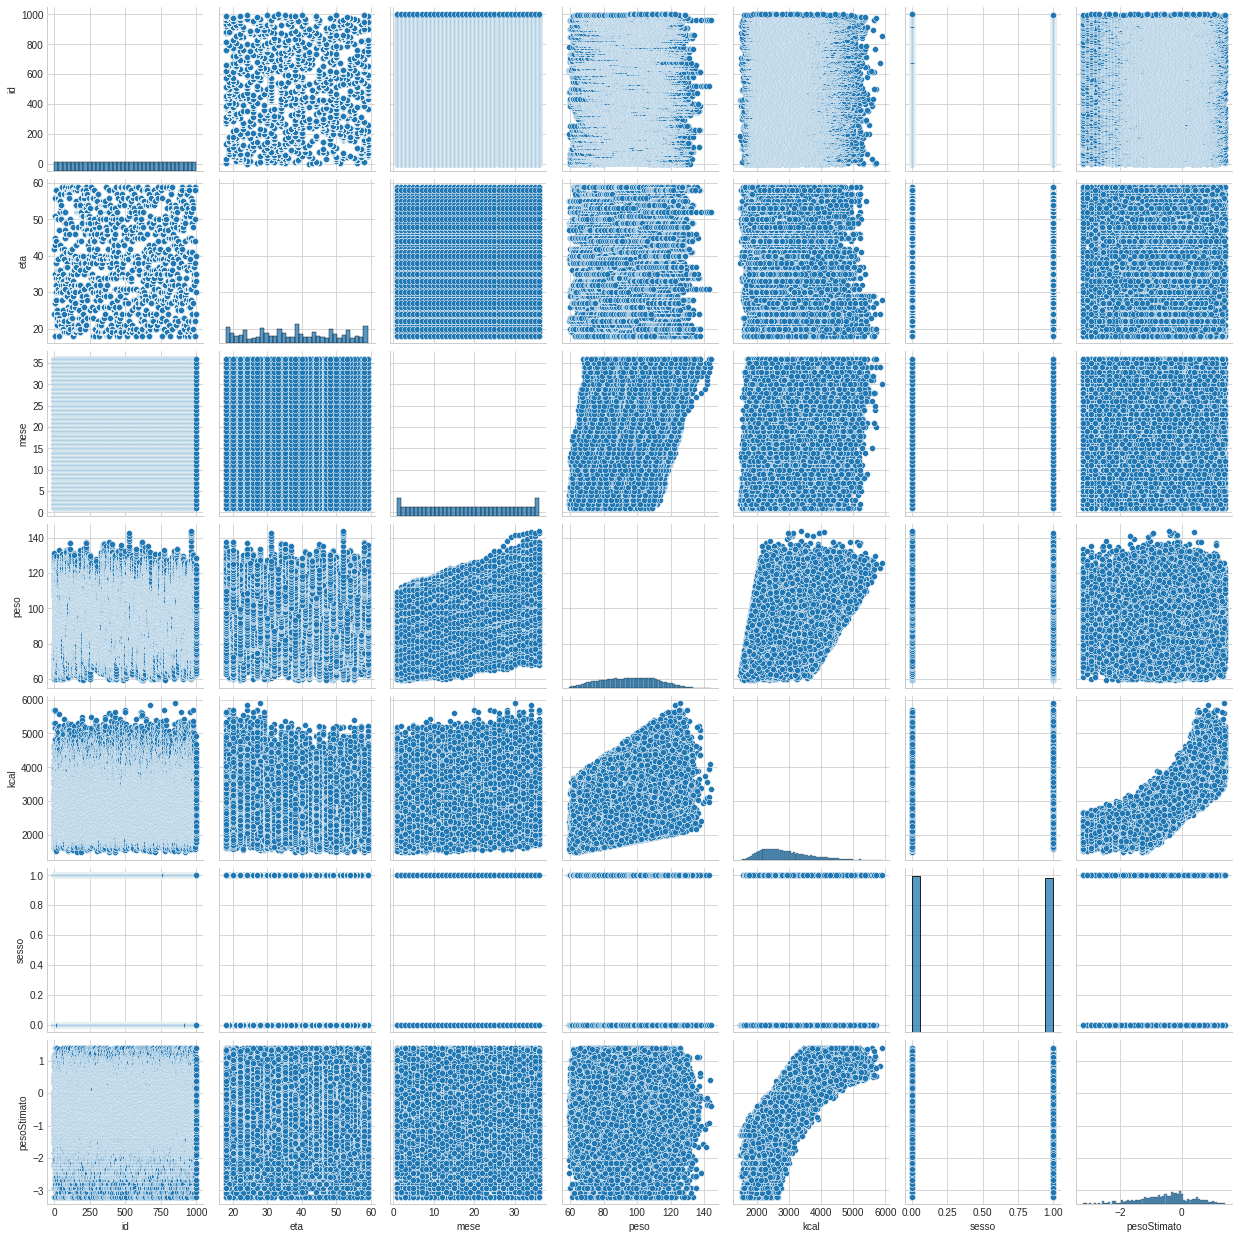

In [2]:
import seaborn as sb
from matplotlib import style

style.use('seaborn-whitegrid')

plt.rcParams['figure.figsize'] = (20,10)

sb.pairplot(df)

plt.savefig('pairplor.png')

### 1.5) Plot Linearità e Multicollinearità

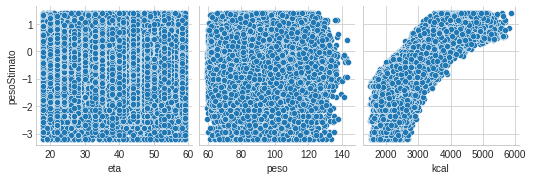

In [ ]:
sb.pairplot(df,x_vars=["eta", "peso", "kcal"], y_vars=["pesoStimato"])

plt.savefig('linearPlot.png')

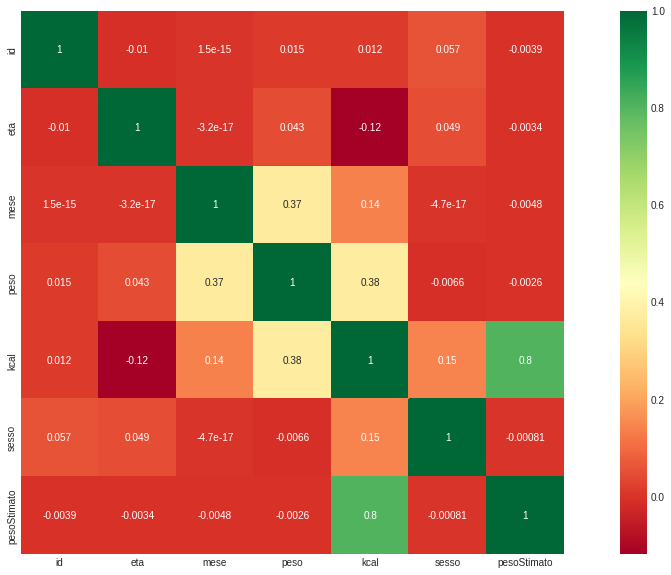

In [ ]:

sb.heatmap(df.corr(), annot=True, cmap="RdYlGn", square=True)

## 2)Divisione in Training e Test Sets, Feature Selection

### 2.1) Definizione Classe Metrics1

In [3]:
import numpy as np
#oggetto che contiene le metriche
class Metrics1:
  #costruttore
  def __init__(self,mae,mse,rmse,model):
    self.mae=mae
    self.mse=mse
    self.rmse=rmse
    self.model=model
     
     
  #ToString
  def __str__(self):
    return f'Metrics [mae= {self.mae} mse= {self.mse} rmse= {self.rmse} mean= {np.mean([self.mae,self.mse,self.rmse])}'

### 2.2) Definizione Classe MetricsResultContainer

In [4]:
class MetricsResultContainer:
  meanMAE = []
  meanMSE = []
  meanRMSE = []
  #costruttore
  def __init__(self,model,alg,param,metricsMean):
    self.model=model
    self.alg=alg
    self.param=param
    self.metricsMean=metricsMean
    self.meanMAE = []
    self.meanMSE = []
    self.meanRMSE = []
  
  def printMetrics(self):
    for m in self.metricsMean:
      self.meanMAE.append(m.mae)
      self.meanMSE.append(m.mse)
      self.meanRMSE.append(m.rmse)
    print("meanMAE=",np.mean(self.meanMAE))    
    print("meanMSE=",np.mean(self.meanMSE))    
    print("meanRMSE=",np.mean(self.meanRMSE))

### 2.3) Definizione funzione generate model 

In [9]:
from sklearn import model_selection
from yellowbrick.base import Visualizer
from re import M
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn import metrics
from yellowbrick.regressor import ResidualsPlot
import statsmodels.api as sm
from termcolor import colored as cl
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip
import matplotlib.pyplot as plt
import copy

def generateModel(alg, model, select):
  #array di metriche (MAE,MSE,RMSE)
  metrics1 = []
  #generazione n_split test/trainig sets
  
  for train_index, test_index in alg.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #applicazione feature select su train_z
    X_train_z = select.fit_transform(X_train, y_train)
    X_test_z = select.transform(X_test)
    
    #training dell'algoritmo sui training set
    model.fit(X_train_z,y_train)
    #validazione modello e applicazione predizione sui testSet
    y_pred = model.predict(X_test_z)
    modelCopy = copy.copy(model)
    #calcolo metriche predizione
    metrics1.append(Metrics1(metrics.mean_absolute_error(y_test,y_pred),
                            metrics.mean_squared_error(y_test,y_pred),
                            np.sqrt(metrics.mean_squared_error(y_test,y_pred)),
                            modelCopy))
  return metrics1

#Scelta variabile dipendente (y) e indipendenti (X)
X=df.drop(columns='pesoStimato')
y=df.pesoStimato
#numero record nel dataset
k=len(df)
#calcolo k ideale da usare nelle tecniche di validazione
k= (k/(k*0.3))
#Kf con k gruppi
kf = KFold(n_splits=int(np.ceil(k)),random_state=42, shuffle=True)
#rKf con k gruppi, e 10 ripetizioni
rkf = RepeatedKFold(n_splits=int(np.ceil(k)), n_repeats=10, random_state=42)
#rkf con 3 gruppi e 10 ripetizioni per questioni della ram del coso
rkfRF = RepeatedKFold(n_splits=3, n_repeats=10, random_state=42)
#instanziazione algritmo per selezione dei KBest individui
select = SelectKBest(f_regression, k=4)
#risultati: array di array di metriche
metricsResults = []

## 3) Model Testing

### 3.1) Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression
print("Linear Regression - KF")
m = MetricsResultContainer("Linear Regression","KF","Default",
  generateModel(kf,LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nLinear Regression - RKF")
m = MetricsResultContainer("Linear Regression","RKF","Default",
  generateModel(rkf, LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()


Linear Regression - KF
meanMAE= 0.3811471061411685
meanMSE= 0.24157634509065812
meanRMSE= 0.49023471211278447

Linear Regression - RKF
meanMAE= 0.37915589092421786
meanMSE= 0.23819726373611236
meanRMSE= 0.4863395045552313


### 3.2) DecisionTree Regression

In [7]:
from sklearn.tree import DecisionTreeRegressor
print("DecisionTreeRegressor - KF")
m = MetricsResultContainer("DecisionTree Regression","KF","Default",
  generateModel(kf, DecisionTreeRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nDecisionTreeRegressor - RKF")
m = MetricsResultContainer("DecisionTree Regression","RKF","Default",
  generateModel(rkf, DecisionTreeRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

DecisionTreeRegressor - KF
meanMAE= 0.4612308976100833
meanMSE= 0.396651112517309
meanRMSE= 0.6259515911110547

DecisionTreeRegressor - RKF
meanMAE= 0.44868641521020003
meanMSE= 0.3803750048623872
meanRMSE= 0.6127639483254377


### 3.3) Random Forest Regression

In [8]:
from sklearn.ensemble import RandomForestRegressor

print("RandomForestRegressor - KF")
m = MetricsResultContainer("RandomForest Regression","KF","Default",
  generateModel(kf, RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRandomForestRegressor  - RKF")
m = MetricsResultContainer("RandomForest Regression","RKF","Default",
  generateModel(rkfRF,RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

RandomForestRegressor - KF
meanMAE= 0.35099640743445737
meanMSE= 0.2151342407918251
meanRMSE= 0.4607740272340182

RandomForestRegressor  - RKF
meanMAE= 0.32701465747057235
meanMSE= 0.19221778071158566
meanRMSE= 0.43502500931426624


### 3.4) SVR Regression

In [ ]:
from sklearn.svm import SVR
print("SVR - KF")
m = MetricsResultContainer("SVR Regression","KF","Default",
  generateModel(kf, SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nSVR - RKF")
m = MetricsResultContainer("SVR Regression","RKF","Default",
  generateModel(rkfRF, SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

SVR - KF
meanMAE= 0.35700174956626574
meanMSE= 0.22499572201507276
meanRMSE= 0.47188835446940575

SVR - RKF
meanMAE= 0.34261666808504593
meanMSE= 0.209580325738817
meanRMSE= 0.4553044741127915


### 3.5) Lasso Regression

In [ ]:
from sklearn import linear_model
lassoReg = linear_model.Lasso()
print("Lasso Regression - KF")
m = MetricsResultContainer("Lasso Regression","KF","Default",
  generateModel(kf, lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nLasso Regression - RKF")
m = MetricsResultContainer("Lasso Regression","RKF","Default",
  generateModel(rkfRF, lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()

Lasso Regression - KF
meanMAE= 0.3980451225536232
meanMSE= 0.2593319425346561
meanRMSE= 0.5074380133097707

Lasso Regression - RKF
meanMAE= 0.3845327145017947
meanMSE= 0.24317053716080395
meanRMSE= 0.49133867079542465


### 3.6) Ridge Regression

In [ ]:
from sklearn import linear_model
bridgeReg = linear_model.Ridge()
print("Ridge Regression - KF")
m = MetricsResultContainer("Ridge Regression","KF","Default",
  generateModel(kf, bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRidge Regression - RKF")
m = MetricsResultContainer("Ridge Regression","RKF","Default",
  generateModel(rkfRF, bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()

Ridge Regression - KF
meanMAE= 0.38114739175077417
meanMSE= 0.24157636339354047
meanRMSE= 0.49023472962648257

Ridge Regression - RKF
meanMAE= 0.36819125061567437
meanMSE= 0.22706692017787572
meanRMSE= 0.4747472966113625
